# Company bankrupcy prediction

Companies are the engines of a free market economy. Having their smaller economical worlds they try to do their best at staying on the flow in the big competition.

In this notebook I try to take in cosideration financial aspects of companies in order to determine their potential to go bankrupt.

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Dataset

This dataset is sourced from kaggle. 
https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

I find this dataset suitable since it has what I believe has the most impact on the prediction: Net income, Return on assets (ROA) and Debt ratio. Things the professional I consulted also were mentioned as useful. It is indeed real data from the Taiwan Economic Journal for the years 1999 to 2009. It is all numeric, easy to work with. I dont have to deal with duplicated data or missing data.

In [38]:
brDf = pd.read_csv('data.csv')
print(brDf.shape)
brDf

(6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [39]:
brDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

### Checking for missing data


In [40]:
print(f"missing data among all columns: {brDf.isnull().sum().sum()}")

missing data among all columns: 0


### Checking for duplicates

In [41]:
print("duplicated data among columns:")
brDf.duplicated().value_counts()

duplicated data among columns:


False    6819
dtype: int64

## Visualisation
To have a better perspective on how the other features correlate with the bankrupt state, I decided to use a heatmap. Even though these are quite alot of features to be visualised on a heatmap, I believe it is the easiest and a very quick way of manually detecting corelations to choose features for the modeling.

Creating one with all the features would result in something like this:

<AxesSubplot:>

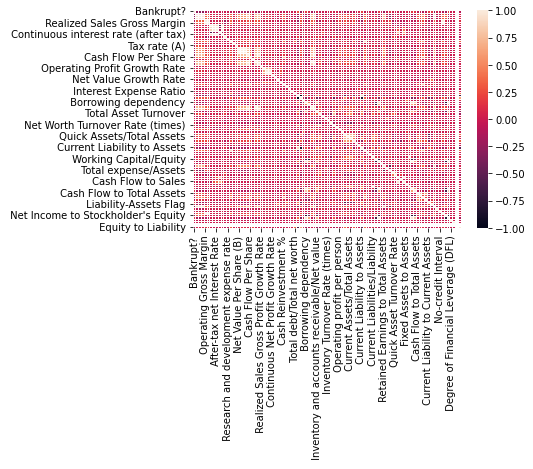

In [42]:
sns.heatmap(brDf.corr(), linewidths=.5)

This heatmap can be defined as unreadable so I decided to remove all the corelations lower than 0.2 and chose from them.

It will be splitted in two graphs with negative and positive since it is easier programming-wise.
I will start with negative correlations.

<AxesSubplot:>

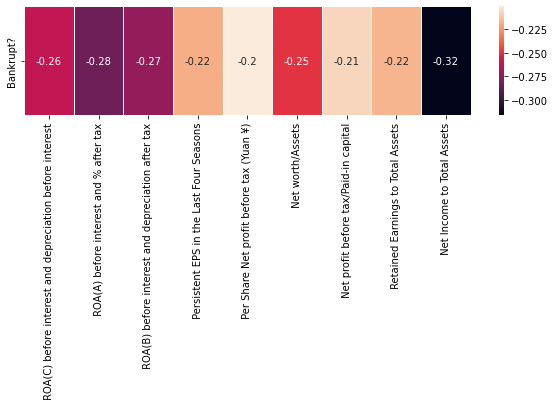

In [43]:
fig, ax = plt.subplots(figsize=(10,2))
df_corr = brDf.corr().loc[:,brDf.columns.intersection(['Bankrupt?'])]
negative_corr = df_corr[df_corr['Bankrupt?'] < -0.2]
sns.heatmap(negative_corr.T, linewidths=.5, ax = ax, annot = True)


In this case the darker the colors are, the better. 

Now I will generate one with positive correlations.

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

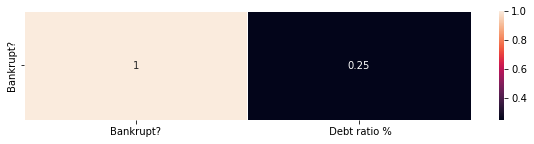

In [44]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,2))
positive_corr = df_corr[df_corr['Bankrupt?'] > 0.2]
sns.heatmap(positive_corr.T, linewidths=.5, ax = ax, annot = True)

Here we can see that the feature that the specialist I consulted mentioned has the highest positive correlation.

Indeed the correlations are not high, but using them all together can give a worthy result.

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Splitting data

From the heatmap, I chose five features that corelate the most. (Net Income to Total Assets, Net worth/Assets, ROA(B) before interest and depreciation after tax, Current Liability to Assets, Debt ratio). They match my earlier intetions while choosing the dataset.

This data will be used in the first three iterations.

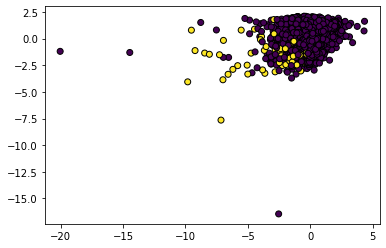

In [46]:
# Normalize
df_forscale = brDf[[' Net Income to Total Assets', ' Net worth/Assets', ' ROA(B) before interest and depreciation after tax',' Current Liability to Assets',' Debt ratio %']]
scaler_brankrupt = StandardScaler().fit(brDf.loc[:,df_forscale.columns])
scaled = scaler_brankrupt.transform(brDf.loc[:,df_forscale.columns])

X_train, X_test, y_train, y_test = train_test_split(scaled, brDf['Bankrupt?'],test_size=0.25 , random_state=42)
plt.scatter(X_train[:,0], X_train[:,1], edgecolors='k', c=y_train)

# Modeling Iterations

Since different approaches give different results, I ended up doing multiple iterations to get the best possible answers. These Iterations include different usage of models and data preparation.


## Iteration 1

To start I will try to predict by using a kNN classifier since it is the fastest and the easiest.

### Modeling

In [47]:
model_1 = KNeighborsClassifier(5)
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)

### Evaluation

In [48]:
print(classification_report(y_test, pred_1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1647
           1       0.50      0.21      0.29        58

    accuracy                           0.97      1705
   macro avg       0.74      0.60      0.64      1705
weighted avg       0.96      0.97      0.96      1705



The precision is 50%, which it basically means that the model choses fully randomly, maybe I should change the modeling algorithm.

## Iteration 2

### Modeling

This time I chose SVC, because it is often works nicely when used for classification, it is known for producing high accuracy and also for being decently fast. I will use the standard kernel 'rbf'.

In [49]:
model_2 = SVC(kernel = 'rbf')
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)

acc_2 = accuracy_score(pred_2, y_test)

print(acc_2)

0.967741935483871


### Evaluation

In [50]:
print(classification_report(y_test, pred_2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.80      0.07      0.13        58

    accuracy                           0.97      1705
   macro avg       0.88      0.53      0.56      1705
weighted avg       0.96      0.97      0.95      1705



I find the precision decent, but the recall is pretty low. I will keep going with SVC, but maybe I should experiment more with the kernels.

## Iteration 3

### Modeling

The polynominal kernel is similar to rbf, but it creates the plane diffirently which might end up in a different result.

In [51]:
model_3 = SVC(kernel = 'poly')
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)

from sklearn.metrics import accuracy_score
acc_3 = accuracy_score(pred_3, y_test)

print(acc_3)

0.967741935483871


### Evaluation

In [52]:
print(classification_report(y_test, pred_3))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       1.00      0.05      0.10        58

    accuracy                           0.97      1705
   macro avg       0.98      0.53      0.54      1705
weighted avg       0.97      0.97      0.95      1705



There is indeed an increase in precision, but the recall is not very presentable.

## Conlcusion

The model gave a 25% increase in precision, but the recall is pretty low giving me a 10% f1 score which is not what I aimed for. Also, I am not satisfied by the confusion matrix results which asks for a new iteration.

## Iteration 4

## Preprocessing

After consulting with my Machine Learning mentor (Bas), I decided I would take a look in the column to see the difference in the number of bankrupt and non-bankrupt data.

0    6599
1     220
Name: Bankrupt?, dtype: int64

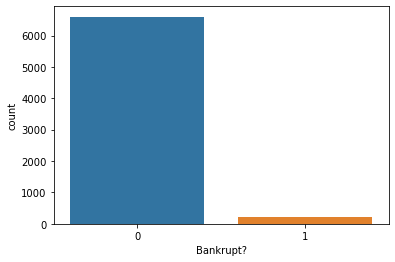

In [54]:
df_count = brDf['Bankrupt?'].value_counts()
sns.countplot(x = 'Bankrupt?', data = brDf)
df_count

Indeed, the difference is huge. I will try to equalize the numbers by cutting off random non-bankrupt ones.

1    220
0    220
Name: Bankrupt?, dtype: int64

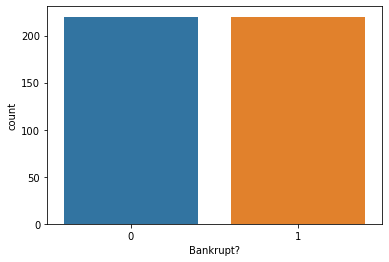

In [55]:
drop_indices = np.random.choice(brDf['Bankrupt?'].loc[lambda x: x==0].index, 6379, replace=False)
df_subset = brDf.drop(drop_indices)
df_subset = df_subset.reset_index()

df_subset_count = df_subset['Bankrupt?'].value_counts()
sns.countplot(x = 'Bankrupt?', data = df_subset)
df_subset_count

### Splitting the data
I will keep the same features.

,index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,6668,0,0.623653,0.671827,0.657905,0.637102,0.637102,0.999344,0.797950,0.809738,...,0.875581,0.000898,0.624010,0.637101,0.844407,0.275970,0.026791,0.565158,1,0.085352
436,6728,1,0.492176,0.544320,0.533326,0.618105,0.618105,0.999083,0.797456,0.809338,...,0.800780,0.000517,0.623737,0.618104,0.840533,0.282763,0.027033,0.566098,1,0.022209
437,6740,0,0.525130,0.589839,0.575941,0.607943,0.607979,0.999094,0.797534,0.809437,...,0.828175,0.004590,0.623310,0.607944,0.842725,0.280072,0.026793,0.565168,1,0.028190
438,6747,0,0.540828,0.599706,0.583918,0.608513,0.608498,0.999130,0.797551,0.809437,...,0.830563,0.004841,0.624039,0.608513,0.842610,0.278766,0.026812,0.565254,1,0.033930


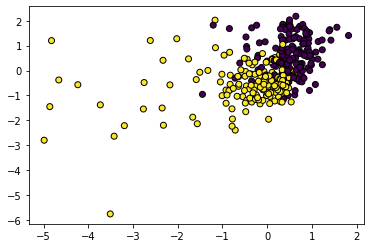

In [56]:
df_forscale = df_subset[[' Net Income to Total Assets', ' Net worth/Assets', ' ROA(B) before interest and depreciation after tax',' Current Liability to Assets',' Debt ratio %']]
scaler_brankrupt = StandardScaler().fit(df_subset.loc[:,df_forscale.columns])
scaled = scaler_brankrupt.transform(df_subset.loc[:,df_forscale.columns])

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(scaled, df_subset['Bankrupt?'],test_size=0.25 , random_state=42)
plt.scatter(X_train_1[:,0], X_train_1[:,1], edgecolors='k', c=y_train_1)
df_subset

## Modeling

### KNN

In [82]:
model_4 = KNeighborsClassifier(5)
model_4.fit(X_train_1, y_train_1)
pred_4 = model_4.predict(X_test_1)
acc_4 = accuracy_score(y_test_1, pred_4_1)
print(acc_4)

0.8545454545454545


### SVC Classic

In [74]:
model_4_1 = SVC(kernel = 'rbf')
model_4_1.fit(X_train_1, y_train_1)
pred_4_1 = model_4_1.predict(X_test_1)
acc_4_1 = accuracy_score(y_test_1, pred_4_1)
print(acc_4_1)

0.8545454545454545


### SVC Poly

In [75]:
model_4_2 = SVC(kernel = 'poly')
model_4_2.fit(X_train_1, y_train_1)
pred_4_2 = model_4_2.predict(X_test_1)
acc_4_2 = accuracy_score(y_test_1, pred_4_2)
print(acc_4_2)

0.8818181818181818


### SVC Sigmoid

In [91]:
model_4_3 = SVC(kernel = 'sigmoid')
model_4_3.fit(X_train_1, y_train_1)
pred_4_3 = model_4_3.predict(X_test_1)
acc_4_3 = accuracy_score(y_test_1, pred_4_3)
print(acc_4_3)

0.8363636363636363


## Evaluation

In [94]:
print(classification_report(y_test_1, pred_4))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        52
           1       0.86      0.84      0.85        58

    accuracy                           0.85       110
   macro avg       0.84      0.85      0.85       110
weighted avg       0.85      0.85      0.85       110



In [95]:
print(classification_report(y_test_1, pred_4_2))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        52
           1       0.86      0.93      0.89        58

    accuracy                           0.88       110
   macro avg       0.89      0.88      0.88       110
weighted avg       0.88      0.88      0.88       110



An f1 score of 89 is indeed very good and I can go further.

### Confusion matrix kNN

<AxesSubplot:>

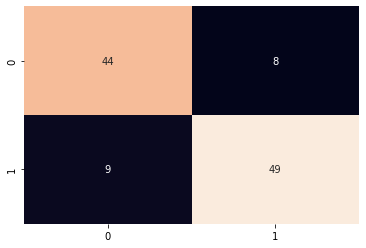

In [88]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_1, pred_4)
sns.heatmap(matrix, annot=True, cbar=None)

### Confusion matrix SVC Poly

I chose this one over the others due to higher accuracy.

<AxesSubplot:>

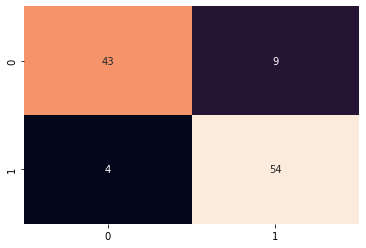

In [89]:
matrix = confusion_matrix(y_test_1, pred_4_2)
sns.heatmap(matrix, annot=True, cbar=None)

In this project, a true positive has big significance, it is more valuable for the algorithm to tell its user that the company will go bankrupt, which if true, he will take measures in attempt to prevent that, otherwise making no changes will lead to an actual bankrupcy. In some cases even if the user gets a false positive, stressing out and attepmting to optimise the company more would not hurt its financial status, thus making false positives preferable to false negatives.

The confusion matrix for the SVC Poly shows that the model did very good at predicting True Positives, and gives very few false negatives. Along with good True negatives.

## Conclusion

The current prediction (Iteration 4) is much more satisfying with a precision of 78 and a recall of 93. Indeed the test was a bit tuned in order to get a more fair challenge to test the model's recall capabilities. But precision was high in both test environments and a positive should not be ignored when getting one.